## Binary image 
Agnieszka Dutka

In [40]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import numpy as np
from random import randint, random
from math import exp
import os

### Useful structures

In [14]:
class OptimState:
    def __init__(self, val, cost):
        self.val = val
        self.cost = cost

    def __str__(self):
        return f"image:\n{self.val}\ncost: {self.cost}\n"

### Binary image generator

In [15]:
def createBinImage(n: int, d:float):
    """ create new binary image nxn, with dark point density d"""
    bim = np.zeros((n, n))
    for r in range(n):
        for c in range(n):
            if random() < d:
                bim[r, c] = 1
    return bim

### General cost function for binary image format

In [103]:
def countPointEnergy(bim, r, c, neighNr, eFunc):
    cost =0
    x = [-1, 0, 1, 0]  # 4 closest neighbours
    y = [0, 1, 0, -1]
    for i in range(4):
        cost += eFunc(bim, r, c, x[i], y[i], 1)
    if neighNr == 4:
        return cost
    x = [-1, 1, 1, -1]  # 8 closest neighbours
    y = [1, 1, -1, -1]
    for i in range(4):
        cost += eFunc(bim, r, c, x[i], y[i], np.sqrt(2))
    if neighNr == 8:
        return cost
    iter= [-2, -1, 0, 1, 2] # 16 neighbours
    for i in iter:
        cost += eFunc(bim, r, c, i, -2)
        cost += eFunc(bim, r, c, i, 2)
        if abs(i) != 2:
            cost += eFunc(bim, r, c, -2, i)
            cost += eFunc(bim, r, c, 2, i)
    return cost

def costFunc(bim, neighNr, energyFunc, prevstate=None, changed=None):
    assert neighNr in [4, 8, 16], "only options: neighNr = 4, 8 or 16!"
    n = bim.shape[0]
    cost = 0.
    if prevstate is None:  # no previous results
        for r in range(n):
            for c in range(n):
                cost += countPointEnergy(bim, r, c, neighNr, energyFunc)
    else:
        cost = prevstate.cost
        for point in changed:
            cost -= countPointEnergy(prevstate.val, point[0], point[1], neighNr, energyFunc)
            cost += countPointEnergy(bim, point[0], point[1], neighNr, energyFunc)
    return cost

## SA algortihm

In [105]:
def SAforBinImage(energyF, x, nextState, neighNr=4, iter=5000, T=100., alpha=0.99, show=0):
    alpha = alpha
    state = OptimState(x, costFunc(x, neighNr, energyF))
    costs = [(0, state.cost)]
    frames = [x]
    for i in range(iter):
        newX, changedPts = nextState(state.val)
        newState = OptimState(newX, costFunc(newX, neighNr, energyF, state, changedPts) ) # , state, changedPts

        # decide whether change state
        delta = newState.cost - state.cost
        if delta <= 0:
            state.val = newState.val
            state.cost = newState.cost
        else:
            P =exp(-delta / T)
            if random() <= P:
                state = newState

        T = T*alpha
        
        if (show>0 and i %show == 0):
            frames.append(state.val)
            costs.append((i+1, state.cost))
            
    if show > 0:
        return state, frames, costs    
    return state

### next Value functions

In [106]:
def nextStateRnd(bim):
    n = bim.shape[0]
    x1 = randint(0, n - 1)
    y1 = randint(0, n - 1)

    x2 = randint(0, n - 1)
    y2 = randint(0, n - 1)

    while x1==x2 and y1==y2:
        x2 = randint(0, n - 1)
        y2 = randint(0, n - 1)

    res = np.copy(bim)
    res[x1, y1] = bim[x2, y2]
    res[x2, y2] = bim[x1, y1]

    return res, [[x1, y1], [x2, y2]]

def nextStateNeigh(bim):
    n = bim.shape[0]
    while(True):
        x1 = randint(0, n - 1)
        y1 = randint(0, n - 1)
        x2Opt = [x1+1, x1, x1-1, x1]
        y2Opt = [y1, y1+1, y1, y1-1]
        OptIdx = randint(0, 3)
        x2 = x2Opt[OptIdx]%n
        y2 = y2Opt[OptIdx]%n
        if bim[x1, y1] != bim[x2, y2]:
            break

    res = np.copy(bim)
    res[x1, y1] = bim[x2, y2]
    res[x2, y2] = bim[x1, y1]
    return res, [[x1, y1], [x2, y2]]

### energy functions

In [107]:
def energyFuncStripes(bim, x, y, xOffs, yOffs, dist=None):
    n = bim.shape[0]
    if dist is None:
        dist = np.sqrt(xOffs**2+yOffs**2)
    if x+xOffs>=n or x+xOffs<0 or y+yOffs>=n or y+yOffs<0:
        return 0
    if bim[x, y]==bim[x+xOffs, y+yOffs]==1:
        return -5*dist
    else:
        return 0


def energyFuncClassic(bim, x, y, xOffs, yOffs, dist=None):
    n = bim.shape[0]
    if dist is None:
        dist = np.sqrt(xOffs**2+yOffs**2)
    if x+xOffs>=n or x+xOffs<0 or y+yOffs>=n or y+yOffs<0:
        return 0
    if bim[x, y]==bim[x+xOffs, y+yOffs]==1:
        return -5/dist
    else:
        return 0
    
def energyFuncRepel(bim, x, y, xOffs, yOffs, dist=None):
    n = bim.shape[0]
    if dist is None:
        dist = np.sqrt(xOffs**2+yOffs**2)
    if x+xOffs>=n or x+xOffs<0 or y+yOffs>=n or y+yOffs<0:
        return 0
    if bim[x, y]==bim[x+xOffs, y+yOffs]==1:
        return 5/dist
    else:
        return 0

### Run without animation and save result to file
recommended for big files

In [108]:
def runWithParams(n, d, energyFunc, nextStateFunc, neighNr, T=100., alpha=0.99, subfolderName="unnamed"):
    outDir = "results"
    if not os.path.exists(outDir):
        os.mkdir(outDir)
    if not os.path.exists(f"{outDir}/{subfolderName}"):
        os.mkdir(f"{outDir}/{subfolderName}")
    bim = createBinImage(n, d)
    plt.imsave(f'{outDir}/{subfolderName}/input_n{neighNr}_T{T}_a{alpha}.png', bim, cmap=cm.gray)
    res = SAforBinImage(energyFunc, bim, nextStateFunc, neighNr=16, iter=6000, alpha=alpha, T=T)
    plt.imsave(f'{outDir}/{subfolderName}/result_n{neighNr}_T{T}_a{alpha}.png', res.val, cmap=cm.gray)

runWithParams(128, 0.2, energyFuncClassic, nextStateNeigh, neighNr=16, T=100,alpha=0.99,subfolderName= "classic")

## Animation of SA algorithm 

<IPython.core.display.Javascript object>


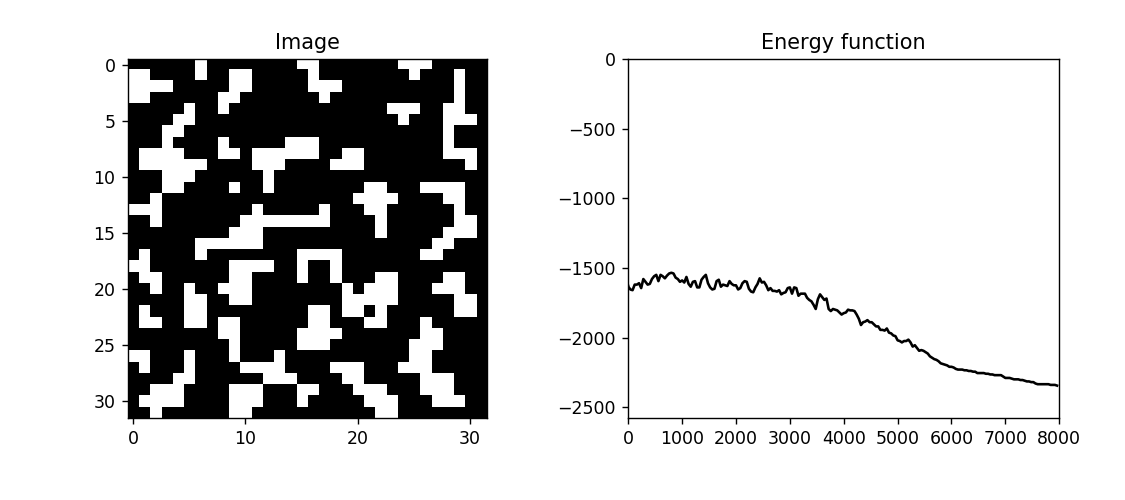

In [116]:
%matplotlib nbagg

# ---- PARAMTERS ------
n, d = 32, 0.3
energyFunc = energyFuncClassic
nextStateFunc = nextStateNeigh
neighNr = 4  # one of: 4, 8, 16
iter = 8000
T, alpha = 360, 0.999
show_every_nth = 40


# run --------------------
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
fig.tight_layout(pad=3.0)

bim = createBinImage(n, d)
res, frames, costs = SAforBinImage(\
energyFunc, createBinImage(n, d), nextStateFunc, neighNr=neighNr, iter=iter, T=T, alpha=alpha, show=show_every_nth)

# initializing animation------------
image = ax[0].imshow(bim, cmap=plt.cm.gray)
ax[0].set_title("Image")
cost_line, = ax[1].plot([], [], 'k-')
ax[1].set_xlim(0, iter)
endCost = costs[len(costs)-1][1]
if endCost >0:
    ax[1].set_ylim(0, endCost*1.1)
else:
    ax[1].set_ylim(endCost*1.1, 0)
    
ax[1].set_title("Energy function")
xcost, ycost = [], []

# update ------------------
def updateFunc(i):
    frame = frames[int(i)]
    xcost.append(costs[int(i)][0])
    ycost.append(costs[int(i)][1])
    
    image.set_data(frame)
    cost_line.set_data(xcost, ycost)
    return image, cost_line

ani = animation.FuncAnimation(fig, updateFunc, frames=np.linspace(0, len(frames)-1, len(frames)),
                              interval=1, repeat=False)

plt.show()